In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


    # E = - J(ij)^mu * state ij * Threshold

    # energy calculation with single pattern
    J_matrix = pattern_vector * pattern_vector_transpose
    factor =  random_vector* J_matrix * random_vector_transpose 
    Energy = factor * step_threshold(pattern_vector * random_vector - k )

    # Energy for multiple patterns:
    net_J_matrix = J_matrix_pattern1 * step_threshold(pattern1_vector*random_vector-k) + J_matrix_pattern2 * step_threshold(pattern2_vector*random_vector-k) +.... so on

    Energy  = random_vector * net_J_matrix * random_vector_transpose

    # sum from pattern matrix 



In [3]:

def step_threshold(x,k):
    return float(x>=k)

def energy_calc(random_vector, patterns , k,size ):

    random_vector = random_vector.reshape(-1,1)
    net_J_matrix = np.zeros((random_vector.shape[0], random_vector.shape[0]))

    for pattern in patterns:
        pattern = pattern.reshape(-1,1) # column vector, (n,1)
        J_matrix = (pattern @ pattern.T)/size
        threshold_factor = step_threshold(float((pattern.T @ random_vector)/size),k)
        # print("debug")
        # print(pattern.T @ random_vector)
        net_J_matrix += J_matrix * threshold_factor
    #net_J_matrix /= size

    Energy =  -0.5 *float(random_vector.T @ net_J_matrix @ random_vector)

    return Energy


def mc_simulation(size,patterns,k, epochs,temp):
    x = np.random.choice([-1,1], size = (size,))
    overlap_history = []
    
    for epoch in range(epochs):
        flip_index = np.random.randint(0,size)
        x_flipped = x.copy()
        x_flipped[flip_index] *= -1

        energy_x = energy_calc(x,patterns,k, size)
        energy_x_flip = energy_calc(x_flipped, patterns,k,size)

        energy_diff = energy_x_flip - energy_x

        if energy_diff < 0  or np.random.rand() < np.exp(-energy_diff/temp):
            x = x_flipped

        max_overlap = max(np.dot(x, p)/size for p in patterns)
        overlap_history.append(max_overlap)

    return overlap_history

def mc_simulation_recovery(size,patterns,k, epochs,temp):
    x = np.random.choice([-1,1], size = (size,))
    overlap_history = []
    
    for epoch in range(epochs):
        flip_index = np.random.randint(0,size)
        x_flipped = x.copy()
        x_flipped[flip_index] *= -1

        energy_x = energy_calc(x,patterns,k, size)
        energy_x_flip = energy_calc(x_flipped, patterns,k,size)

        energy_diff = energy_x_flip - energy_x

        if energy_diff < 0 or np.random.rand() < np.exp(-energy_diff/temp):
            x = x_flipped

    for p in patterns:
        overlap = np.dot(x, p) / size
        if overlap >= 1-(1/size) :  # Successful recovery
            return 1
    return 0  # No recovery





In [5]:
n = 1 # fix
size = 32 # fix
epochs = 1000 # fix
k = 0 # vary
temp =0.02 # maybe



In [6]:
def generate_patterns(n, size):

    return np.random.choice([-1, 1], size=(n, size))


patterns = generate_patterns(n, size)
print(patterns)

[[-1 -1  1  1 -1  1 -1  1  1  1  1 -1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1
  -1  1 -1 -1  1  1  1 -1]]


In [171]:
k_values = [0,0.2,0.3,1]
overlap_list = []
for k in k_values:
    overlap_temp = mc_simulation(size,patterns,k, epochs, temp)
    overlap_list.append(overlap_temp)


/var/folders/5w/wh2htgh56v7ft_7nm78v3rdm0000gn/T/ipykernel_14628/3857668784.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  threshold_factor = step_threshold(float((pattern.T @ random_vector)/size),k)
/var/folders/5w/wh2htgh56v7ft_7nm78v3rdm0000gn/T/ipykernel_14628/3857668784.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Energy =  -0.5 *float(random_vector.T @ net_J_matrix @ random_vector)


## Overlap across each epoch for different k thresholds

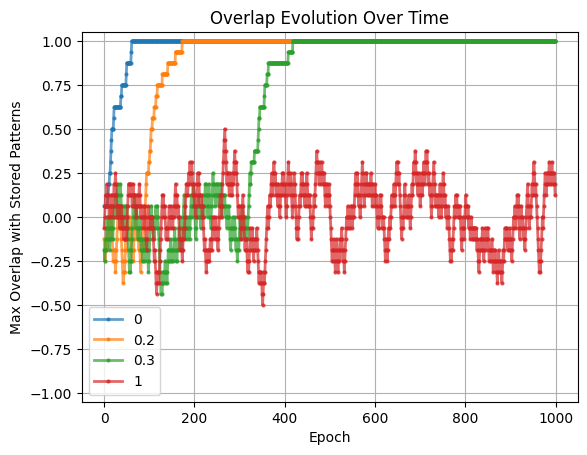

In [172]:
i = 0
for overlap_history in overlap_list:
    plt.plot(overlap_history, marker='o', linewidth = 2, markersize = 2, alpha = 0.7,
             label = f"{k_values[i]}")

    plt.xlabel('Epoch')
    plt.ylabel('Max Overlap with Stored Patterns')
    plt.title('Overlap Evolution Over Time')
    plt.grid(True)
    plt.ylim(-1.05, 1.05)  # normalize range since overlap is in [-1, 1]
    i+=1
plt.legend()
plt.show()

## Recovery Fraction at different thresholds:

/var/folders/5w/wh2htgh56v7ft_7nm78v3rdm0000gn/T/ipykernel_17216/98822307.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  threshold_factor = step_threshold(float((pattern.T @ random_vector)/size),k)
/var/folders/5w/wh2htgh56v7ft_7nm78v3rdm0000gn/T/ipykernel_17216/98822307.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Energy =  -0.5 *float(random_vector.T @ net_J_matrix @ random_vector)


1 Pattern done
3 Pattern done
11 Pattern done
15 Pattern done


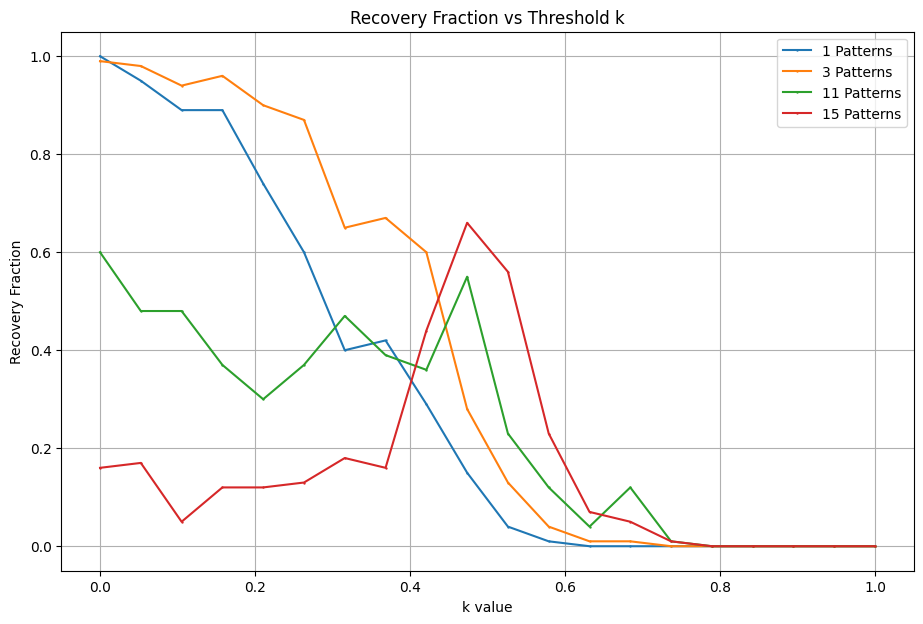

In [11]:

k_values = np.linspace(0, 1, 20)


n_trials = 100
n_list = [1, 3, 11, 15]
size = 32
epochs = 200
temp = 0.03

plt.figure(figsize=(11,7))

for n_value in n_list:
    recovery_fractions = []
    patterns = generate_patterns(n_value, size)
    for k in k_values:
        successes = 0
        for _ in range(n_trials):
            successes += mc_simulation_recovery(size,patterns,k, epochs, temp)
        recovery_fraction = successes / n_trials
        recovery_fractions.append(recovery_fraction)
    print(f"{n_value} Pattern done")


    plt.plot(k_values, recovery_fractions, marker='o', markersize = 0.7,label = f"{n_value} Patterns")
    plt.xlabel('k value')
    plt.ylabel('Recovery Fraction')
    plt.title('Recovery Fraction vs Threshold k')
    plt.grid(True)
    plt.legend()
plt.show()
